### STA663 FINAL PROJECT
# AFFINITY PROPAGATION: THE VERSATILITY OF A CLUSTERING ALGORITHM THAT CONSIDERS ALL POINTS AS CENTERS
#### Lauren Palazzo & Hannah Yan

In [3]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [36]:
# for reproducibility
np.random.seed(1228)

## Abstract

Affinity propagation, proposed by Brendan Frey and Delbert Dueck in 2007, is a clustering algorithm based on the concept of recursively transmitting real-valued messages between datapoints, until a good set of exemplars and corresponding clusters emerges. Unlikesome other clustering algorithms, it does not require pre-specifying the number of clusters. It has the advantage of identifying clusters faster and with lower errors than other methods. In this report, we implement both a basic version and a more efficient vectorized version of the affinity propagation algorithm. We also compare the performance of our algorithm to that of two others, k-means clustering and Gaussian mixture model clustering, and discuss some advantages and disadvantages.

## Background

In affinity propagation, each data point sends messages to all other points informing its targets of each target’s relative attractiveness to the sender. Each target then replies to all informing each sender of its availability to associate with the sender. Senders then follow up with the targets with messages containing the target’s revised relative attractiveness to the sender, based on the availability of all the targets. The procedure iterates until a consensus is reached. 

Some other commonly-used clustering algorithms, such as $k$-means, typically initiate by randomly selecting some points as centers, and then iteratively analyze the suitability of these centers and adjust as needed. This variability in the set of initial centers leads to variability in the final clustering results. Affinity propagation eliminates this variability by considering all points simultaneously as candidate centers. Another advantage of affinity propagration includes its ability to measure the "distance" between points without assuming that points lie within a metrix space (in which case distances would be symmetric). While the similarity measure $s(i,k)$ used in affinity propagation may be set to a symmetric measure such as Euclidean distance, since it is a quantification of how well-suited the latter point is to serve as the center of the former point, it would also be reasonable to define this in a non-symmetric way. This gives the user the ability to explore different types of distance measures when they are working with nonstandard data sets for which the best way to measure similarity between objects is not necessarily obvious, which allows this algorithm to be used on potentially many different kinds of data sets.

Another advantage of affinity propagation (which could also be a disadvantage, depending on one's goals) is that the number of clusters is determined by the algorithm rather than by user pre-specification. To some degree the cluster number can be influenced by the user through the choice of the similarity function and the initial specification of each point's "self-similarity", with lower values in effect lowering each point's likelihood of becoming an exemplar and thus reducing the number of clusters. 

Affinitty propagation is quite computationally efficient. Applications of the algorithm to find exemplars among a set of face photographs and a set of exons in genes have showed that affinity propagation results in not only lower classification error rates, but also runs in substantially less time than $k$-centers clustering. It is possible for the affinity propagation not to converge (i.e., to oscillate between multiple candidate clusterings) in some cases, based on the point similarities. However, adjusting the damping factor or adding a bit of random noise to the similarities can avoid this. 

Affinity propagation is widely utilized. There are R and Python packages that offer automated affinity propagation analysis. A number of published studies have made use of affinity propagation or a related algorithm, for example in the context of clustering gene expression data (Leone et al., 2007) and text from news articles (Guan et al., 2011). 

### How Affinity Propagation works

The similarities, responsibilities, and availabilities are stored in matrices at each iteration of the algorithm. 

#### 1. Similarity matrix

In the similarity matrix, the similarity $s(i, k)$ (for two distinct points, indexed as $i$ and $k$) indicates how well the data points with index $k$ is suited to be the exemplar (i.e., point that serves as a cluster center) for data point $i$. It is calculated using negative squared Euclidean distance in our implementation:
$s(i,k) = - \lVert X[i] - X[k] \rVert ^2$ for a data set X.
For the similarity of a point to itself, i.e. the "self-preference" for being an exemplar, we provide two options in our algorithm: setting all equal to the minimum $s(i,k)$ or to the median $s(i,k)$ for all $i$, $k$ with $i \neq k$. 


#### 2. Responsibility matrix
The responsibility matrix $r(i, k)$ quantified how well-suited $k$ is to serve as the exemplar for $i$, relative to other candidates.
To begin with the availabilities are initialized to be zero. In later iterations, as a data point is assigned to an exmplar, the availability drops below zero and reduce the effect of similarity.   
$$r(i,k) \leftarrow s(i,k) - \max_{k^\prime \text{s.t.} k^\prime \neq k}\{a(i,k^\prime) + s(i, k^\prime)\}$$  
For points on the diagonal, $r(k, k)$ is calculated as the input preference that point k is chosen as an exemplar $s(k,k)$, minus the largest similarity between the point and all other candidate exemplars.  

#### 3. Availability matrix
The availability matrix $a(i, k)$ represents how appropriate it is for $i$ to pick $k$ as its exemplar, taking into account other points' preference for $k$ as an exemplar.  
$$a(i,k)\leftarrow min\{0, r(k,k) + \sum_{i^\prime \text{s.t.} i \notin {i,k}}\max\{0, r(i^\prime,k)\}\} $$  
For points on the diagonal, the following equation is used.  
$$a(k,k) \leftarrow \sum_{i^\prime \text{s.t.} i^\prime \neq k} \max\{0, r(i, k^\prime)\}$$
#### 4. Criterion matrix
The criterion matrix $c(i, k)$ is the sum of the responsibility matrix and the availability matrix  
$c(i, k) \leftarrow r(i, k) + a(i, k) $ 

#### 5. Updates
The message-passing procedure may be terminated after a fixed number of iterations,   
based on changes in the criterion matrix falling below a threshold, or the cluster assignments staying constant for several iterations. In our implementation, the default condition to terminate the algorithm is the cluster assignments not changing for 10 iterations in a row.
A damping factor $\lambda$ (set to 0.5 by default) is applied during the update to avoid numerical oscillations. 
$message = \lambda * message_{t-1} + (1-\lambda)*message_{t}$ where $\lambda \in [0, 1]$ 

#### 6. Identifying clusters
At any iteration, the candidate exemplar for the ith point in the data set is the $k$th point, where $k$ is such that $c(i,k)$ is maximized over all $k$. $c(i,k)$ represents the the sum of the responsibility and the availability that $k$ has to be a center for $i$. Computationally, it is the arg max over $k$ for each row $i$ of the matrix $c(i,k)$.

### Optimization for performance

Given that the initial version of our algorithm used a number of for-loops for filling in array entry, a clear option for optimization was vectorization. That is, we used vector operation for matrix computations instead of forcing each entry to be computed separately. In the function `update_a_array`, the masking-based procedure that was originally used to compute entries in `a_array[niter]` was changed to a process in which a dot product was used to fill in each new row of `a_array[niter]`. This resulted in a decrease in runtime, as seen below. Similarly, `init_r_array` and `r_array_update` were improved to use row vector operations rather than individual entry operations. We also sought to reduce performing unnecessary computations within loops when possible. For example, the list of cluster centers is generated only at the algorithm's final iteration when output is to be printed. We also ran ipython-profiler %%prun to check for bottlenecks in the code and performed unit tests to verify the code. 

Our package includes both the basic function `afprop` and the vectorized version `afprop_vec`. To load our package, the following code is run in the terminal:

!pip install -i https://test.pypi.org/simple/ afprop

We apply both functions to the same data set below. The output for both functions include a scatterplot with color-coded clusters (if the data is two-dimensional), a list of the index of the exemplar for each point, a list of indices of exemplars, the number of exemplars/clusters, and the number of iterations the algorithm went through.

In [37]:
from afprop import afprop
from afprop import afprop_vec

In [41]:
# generate data to be clustered
centers = [[1, 1], [-1, -1]]
mydata, mycenters = make_blobs(n_samples=100, centers=centers,
                  cluster_std=0.5, random_state=0)

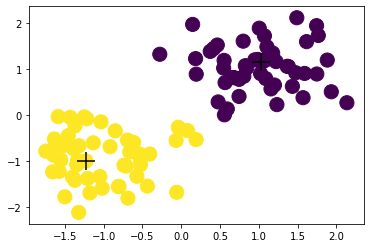

CPU times: user 1min 4s, sys: 280 ms, total: 1min 4s
Wall time: 1min 4s


(array([2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4,
        4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2,
        2, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 2, 4,
        2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2]), array([2, 4]), None, 2, 44)

In [39]:
%%time
afprop(mydata)

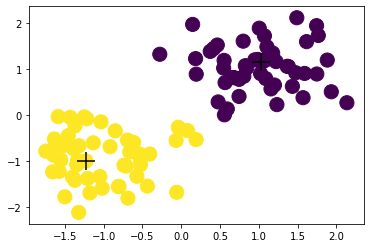

CPU times: user 11.1 s, sys: 208 ms, total: 11.3 s
Wall time: 11 s


(array([2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4,
        4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2,
        2, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 2, 4,
        2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2]), array([2, 4]), 2, 41)

In [42]:
%%time
afprop_vec(mydata)

We see that the total time to run has decreased substantially. 

### Applications to simulated data sets

We generate simply clustered random data, with the true clusters illustrated below. We then apply our affinity propagation algorithm, aprop_vec, and visualize the clsuters it generates. 

In [18]:
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# generate data to be clustered
centers = [[1, 1], [-1, -1], [1, -1]]
mydata, mycenters = make_blobs(n_samples=100, centers=centers,
                  cluster_std=0.5, random_state=0)

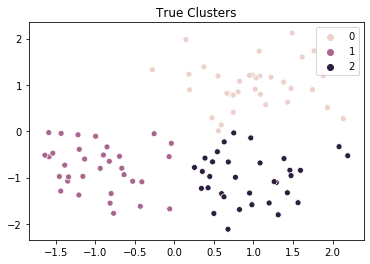

In [16]:
plt.title(f'True Clusters')
sns.scatterplot(mydata[:, 0], mydata[:, 1], hue=mycenters)
plt.show()

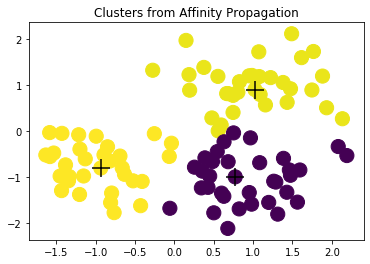

(array([94,  4, 94,  4,  4, 94, 94,  4, 97, 94,  4, 97, 97,  4,  4, 94,  4,
        97,  4, 97, 97, 94, 97, 97, 97, 94, 97, 94, 97,  4, 94, 94, 97,  4,
         4,  4,  4, 94,  4,  4, 94,  4,  4,  4, 97, 94, 97, 94, 97,  4, 94,
        97, 94, 94, 94,  4, 97,  4,  4,  4, 97, 97, 97, 97, 94, 94, 94,  4,
        97, 94, 94, 97, 94,  4, 94, 94, 94, 97, 94, 97, 97,  4,  4, 94,  4,
         4, 94,  4, 94,  4, 94, 97, 97,  4, 94, 97,  4, 97, 97, 97]),
 array([ 4, 94, 97]),
 3,
 35)

In [17]:
plt.title(f'Clusters from Affinity Propagation')
afprop_vec(mydata)

We see that affinity propagation performed well on this simplistically clustered data. We apply it to the moon-shaped data below as well (and also show the sklearn implementation of affinity propagation on this data). 

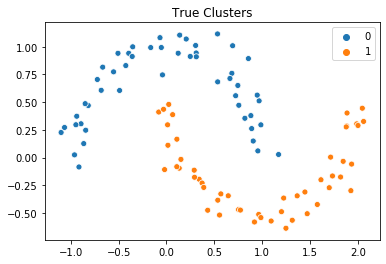

In [7]:
# generate data and illustrate true clusters 
mydata,mycenters = make_moons(n_samples=100, noise=0.1, random_state=0)

plt.title(f'True Clusters')
sns.scatterplot(mydata[:, 0], mydata[:, 1], hue=mycenters)
plt.show()

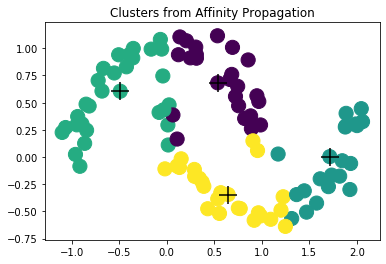

(array([57, 50, 89, 57, 89, 50,  6, 89, 57, 50, 57, 50, 50,  6,  6, 57,  6,
         6, 57,  6, 57, 89,  6, 89, 57, 57,  6, 50, 50, 89, 89, 89, 50, 89,
        57, 57,  6,  6, 89, 89, 50, 89, 57, 57,  6,  6,  6, 57, 57,  6, 50,
        89, 89, 57, 57,  6,  6, 57,  6, 57,  6, 57, 89, 89, 89, 50, 57, 50,
         6, 50,  6, 57, 57, 50, 50, 89,  6, 50, 89, 89, 57, 57, 50, 57, 57,
        89, 89,  6, 50, 89, 50, 57,  6, 50,  6, 50, 89, 89, 57, 57]),
 array([ 6, 50, 57, 89]),
 4,
 40)

In [22]:
# our AP function
plt.title(f'Clusters from Affinity Propagation')
afprop_vec(mydata)

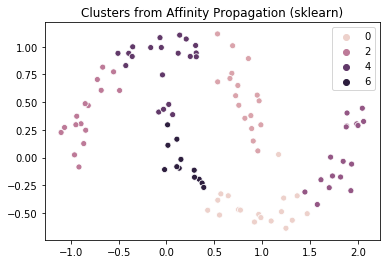

In [23]:
# sklearn's AP function
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference=-3).fit(mydata)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
plt.title(f'Clusters from Affinity Propagation (sklearn)')
sns.scatterplot(mydata[:,0],mydata[:,1],hue=labels)

We see that affinity propagation did not return the "true" clusters in this case, although one could make an argument that in terms of actual Euclidean distance, the affinity propagation clusters are "better". These examples point to the importance of selection of similarity measures in the context of a specific dataset; perhaps if we had used a different similarity measure than Euclidean distance in our algorithm, it would be more able to detect moon-shaped clusters.

### Applications on real data sets

We applied affinity propagation on [UCI Wholesale Customers Dataset](http://archive.ics.uci.edu/ml/datasets/Wholesale+customers), which contains annual spending on different types of grocery products by clients of a wholesale distributor. 

In [4]:
df_original = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')
df=df_original.iloc[:,2:]
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [5]:
# taking a sample 
df2 = df.to_numpy()
idx = np.random.randint(440, size=50)
df3 = df2[idx,:]

In [49]:
# our AP function
afprop_vec(df3)

(array([12, 12, 12, 12, 12, 42, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 42,
        12, 12, 42, 12, 42, 12, 42, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 42, 12, 12, 42, 42, 12, 12, 12, 12, 42, 12, 12]),
 array([12, 42]),
 2,
 56)

Our algorithm returns two clusters of clients of this wholesale distributor, in terms of the types of food and other items they are spending on. The fact that buyers fall into distinct clusters makes sense if we consider that different types of stores and restaurants have several different purchase profiles. For example, fast food restaurants probably buy relatively high volumes of frozen, pre-cooked foods, whereas a grocery store would buy a high volume of fresh produce. A cluster analysis could be useful in, for example, helping a retailer identify what type of buyers comprise their main clusters, and could then further cater their inventory to those customers. 

### Comparative analysis with competing algorithms

We compare affinity propagation with k-means and Gaussian mixture model clustering algorithms. Below is the clustering of our AP algorithm.

In [8]:
# generate data to be clustered
centers = [[1, 1], [-1, -1]]
mydata, mycenters = make_blobs(n_samples=100, centers=centers,
                  cluster_std=0.5, random_state=0)

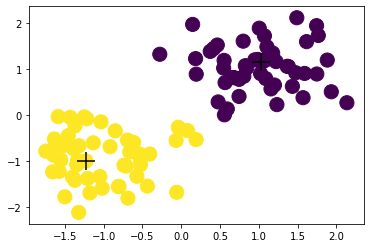

(array([2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4,
        4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2,
        2, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 2, 4,
        2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2]), array([2, 4]), 2, 41)

In [9]:
afprop_vec(mydata)

#### Comparing with k-means clustering

The aim of k-means clustering is to assign points to one of k clusters, where each point is in the cluster whose mean is closest to it. The algorithm works by initally selecting k random points to serve as candidate cluster centers, assigning other points randomly to a cluster, and computing the mean of each cluster. Then the algorithm iterates, re-calculating each cluster's mean and then assigning all non-mean points to the nearest (in terms of squared Euclidean distance) cluster, until stability is achieved in the cluster assignments. 

We try k-means clustering on this data set (with true centers (1,1) and (-1,-1) ) with the number of clusters pre-specified as 2 and then as 3.

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(mydata)
kmeans.cluster_centers_

array([[-0.11730427, -0.93969581],
       [ 1.05404298,  0.83231738]])

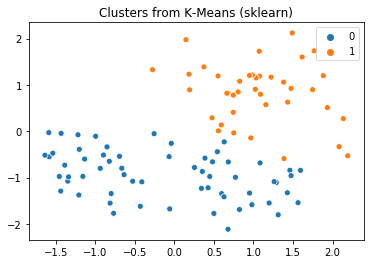

In [20]:
plt.title(f'Clusters from K-Means (sklearn)')
sns.scatterplot(mydata[:,0],mydata[:,1],hue=kmeans.labels_)

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(mydata)
kmeans.cluster_centers_

array([[ 1.00532183,  1.03263888],
       [-0.97632473, -0.75149812],
       [ 0.91482534, -0.99686313]])

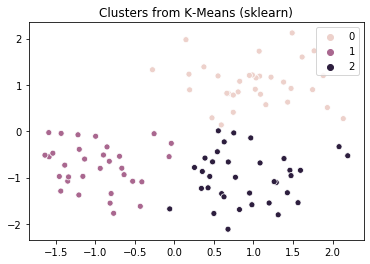

In [22]:
plt.title(f'Clusters from K-Means (sklearn)')
sns.scatterplot(mydata[:,0],mydata[:,1],hue=kmeans.labels_)

We see that when we specify the correct number of clusters, the centers returned by k-means clustering are close to the truth. However, when we specify the wrong number, it seems that one of the two "true" clusters has been divided into two sub-clusters to have a total of three. This demonstrates how the need to pre-specify the number of clusters in k-means can lead to dubious results. In particular, if the number of true clusters is two and we request three, we may expect that one of the two true clusters will be divided into two, but it may be arbitrary which one of the two true clusters is "chosen" for this. 

#### Comparing with Gaussian mixture model-based clustering

Clustering with Gaussian mixture models is similar in a way to k-means clustering, but includes assumptions about the data-generating process. GMM assumes that data is generated by a mixture of Gaussian distributions, with the number of distributions pre-specified by the user. It initiates with random guesses as to what the parameters of these distributions are. Then it calculates the likelihood of each points being generated by each distribution, and then uses this information to update the parameters of the distributions. This process is iterated until an optimal specification of parameters is achieved. 

If we simulate data that is indeed generated from Gaussian (normal) distributions, then we would expect GMM clustering to effectively detect these clusters, as affinity propagation did. We compare the two algorithms on non-normal data below.

(Note: To illutrate the GMM results, some code in the chunk below was borrowed from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html.)

In [27]:
# some borrowed plotting code here

from sklearn import mixture

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)


We will also compare these algorithms for the non-Gaussian moon-shaped data.

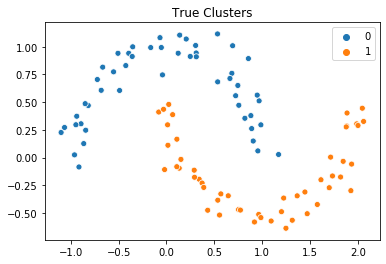

In [24]:
# generate data and illustrate true clusters 
mydata,mycenters = make_moons(n_samples=100, noise=0.1, random_state=0)

plt.title(f'True Clusters')
sns.scatterplot(mydata[:, 0], mydata[:, 1], hue=mycenters)
plt.show()

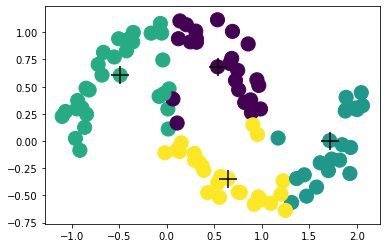

(array([57, 50, 89, 57, 89, 50,  6, 89, 57, 50, 57, 50, 50,  6,  6, 57,  6,
         6, 57,  6, 57, 89,  6, 89, 57, 57,  6, 50, 50, 89, 89, 89, 50, 89,
        57, 57,  6,  6, 89, 89, 50, 89, 57, 57,  6,  6,  6, 57, 57,  6, 50,
        89, 89, 57, 57,  6,  6, 57,  6, 57,  6, 57, 89, 89, 89, 50, 57, 50,
         6, 50,  6, 57, 57, 50, 50, 89,  6, 50, 89, 89, 57, 57, 50, 57, 57,
        89, 89,  6, 50, 89, 50, 57,  6, 50,  6, 50, 89, 89, 57, 57]),
 array([ 6, 50, 57, 89]),
 4,
 40)

In [25]:
afprop_vec(mydata)

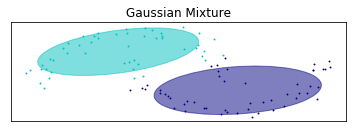

In [28]:
# Fit a Gaussian mixture with EM 
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(mydata)
plot_results(mydata, gmm.predict(mydata), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

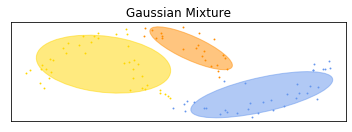

In [29]:
# Fit a Gaussian mixture with EM 
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(mydata)
plot_results(mydata, gmm.predict(mydata), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

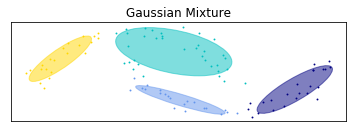

In [30]:
# Fit a Gaussian mixture with EM 
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(mydata)
plot_results(mydata, gmm.predict(mydata), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

The GMM and AP results look somewhat similar when the number of clusters for GMM is set to the same number of clusters that emerged from AP. However, GMM appeared to perform better than AP on this data set when it was given the correct amount of clusters to search for. This highlights how it can be difficult to determine whether a certain clustering algorithm is "better" or "worse" than another to use on a given data set; the parameters and assumptions of the algorithm must be considered in light of what is known about the data.

### Conclusion

Affinity propagation is a clustering algorithm that is able to sidestep the problem of pre-specifying the number of data clusters by considering each point as a candidate cluster center, and iteratively passing messages between points about each point's suitability to be a center for other points. The lack of a need to dictate the number of clusters provides a welcome approach for exploratory data analyses for which there is no a priori evidence for how many true clusters there may be. This algorithm can be implemented in Python in a fairly straightforward way using matrices and for-loops, and thus also has clear potential for optimization through vectorization. 

Although one of the strengths of this algorithm is that it can apply its clustering scheme to nonstandard data, this can also present a limitation if that data does not lend itself well to that clustering scheme. For example, Leone et al. note that in this scheme all points in a cluster must simply be grouped with only one exemplar, and every point either is an exemplar or is not, and so there is no allowance for observing a more nuanced hierachical structure within a cluster. One potential improvement for the algorithm would be to include an option for performing a second round of affinity propagation, in which clustering is performed within each one of the clusters that was labeled in the first round, to identify "sub-exemplars" within each cluster. 

Comparison of affinity propation with two other popular clustering algorithms showed that, despite the increase in flexibility provided by affinity propagation, it is not necessarily clear whether affinity propagation can be expected to come closer to the "correct answer" than another clustering algorithm on a given data set. In conclusion, affinity propagation is a powerful and valuable clustering algorithm, and like all others should be used with an eye towards what is known about the structure and context of one's data. 



### References
Brusco, Michael J., Douglas Steinley, Jordan Stevens, and J. Dennis Cradit. “Affinity Propagation: An Exemplar-Based Tool for Clustering in Psychological Research.” British Journal of Mathematical and Statistical Psychology 72, no. 1 (2019): 155–82. https://doi.org/10.1111/bmsp.12136.  
R. Guan, X. Shi, M. Marchese, C. Yang and Y. Liang, "Text Clustering with Seeds Affinity Propagation," in IEEE Transactions on Knowledge and Data Engineering, vol. 23, no. 4, pp. 627-637, April 2011.
Kang, Jeon Hyung, Kristina Lerman, and Anon Plangprasopchok. “Analyzing Microblogs with Affinity Propagation.” In Proceedings of the First Workshop on Social Media Analytics - SOMA ’10, 67–70. Washington D.C., District of Columbia: ACM Press, 2010. https://doi.org/10.1145/1964858.1964868.  
Michele Leone, Sumedha, Martin Weigt, Clustering by soft-constraint affinity propagation: applications to gene-expression data, Bioinformatics, Volume 23, Issue 20, 15 October 2007, Pages 2708–2715, https://doi.org/10.1093/bioinformatics/btm414
“UCI Machine Learning Repository: Wholesale Customers Data Set.” Accessed April 23, 2020. http://archive.ics.uci.edu/ml/datasets/Wholesale+customers.


In [ ]:
import jovian

In [ ]:
jovian.commit(filename='STA_final_proj_affinity_propagation.ipynb')